In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/dive/MyDrive/VGG_Jetson

[Errno 2] No such file or directory: '/content/dive/MyDrive/VGG_Jetson'
/content


In [ ]:
import tensorflow as tf

In [ ]:
!ls

drive  sample_data  vgg_tflite_dynamicQ.tflite


In [ ]:
model_path = r'/content/drive/MyDrive/VGG_Jetson/model_VGG2_final'

In [ ]:
import tensorflow as tf

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def psnr_loss_fn(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

def ssim_loss_fn(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

In [ ]:
# model = model = tf.keras.models.load_model(model_path)
model = tf.keras.models.load_model(model_path,custom_objects={'charbonnier_loss': charbonnier_loss,
                                              'psnr_loss_fn':psnr_loss_fn,
                                              'ssim_loss_fn':ssim_loss_fn},
                                              compile = False)

## **TFLite Conversion**

In [ ]:
!pwd

/content


In [ ]:
# TF-Lite without Quantization M1
# converter = tf.lite.TFLiteConverter.from_saved_model(model_path) # path to the SavedModel directory
# tflite_model = converter.convert()

# TF-Lite without Dynamic Quantization M2
# converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quant_model = converter.convert()

# FP-16 Conversion M3
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

# Save the model.
with open('vgg_tflite_FP16.tflite', 'wb') as f:
  f.write(tflite_quant_model)

## **Inferenece TF-Lite Model**

In [ ]:
import numpy as np

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='vgg_tflite_dynamicQ.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 204,
  'shape': array([  1, 512, 512,   3], dtype=int32),
  'shape_signature': array([ -1, 512, 512,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)   # dummy input
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print(output_data.shape)

(1, 512, 512, 3)


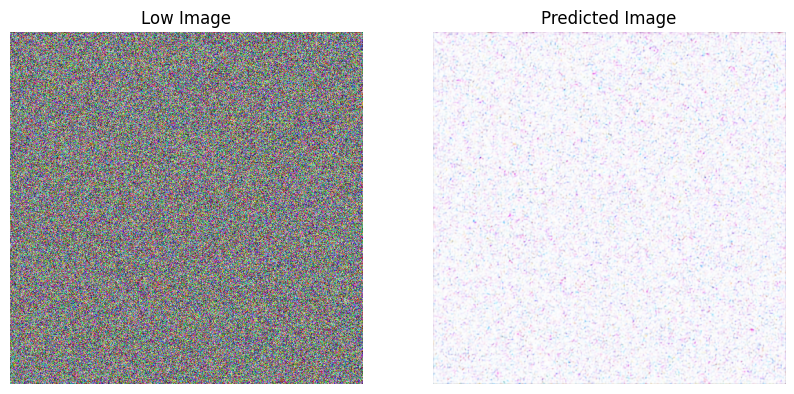

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(10,10));
ax[0].imshow(input_data[0]);
ax[1].imshow(output_data[0]);
ax[0].axis('off');
ax[1].axis('off');
ax[0].set_title("Low Image")
ax[1].set_title("Predicted Image")
plt.show()